# Indeed Job Salary Prediction using Location, Title, and Description of Ad

In this notebook, we'll build a network for sentiment classification on Indeed job ads. We'll be using [TFLearn](http://tflearn.org/), a high-level library built on top of TensorFlow. TFLearn makes it simpler to build networks just by defining the layers. 
We'll start off by importing all the modules we'll need, then load and prepare the data.

In [1]:
import os
os.chdir('../')

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tflearn
import json
from tflearn.data_utils import to_categorical
from collections import Counter, defaultdict
from sklearn.feature_extraction import stop_words
from lib.indeed_parsing import extract_posts_w_salary_to_df, extract_posts_to_df
from lib.preprocess import preprocess_w_salary, preprocess_wo_salary

## Scraping job listings from Indeed.com
We will be scraping job listings from Indeed.com using extract_posts_w_salary_to_df query function that I built. As inputs, it takes a list of keywords like 'data scientist' or 'machine learning', a list of cities that you want the job posts to be pulled from and an integer for maximum results per page. This function filters the posts that contain salary. 

In [3]:
cities = ['los angeles','chicago','san francisco','seattle','new york','austin',
          'philadelphia','atlanta','dallas','portland','phoenix','denver',
          'houston','miami','washington']

In [4]:
df = extract_posts_w_salary_to_df(keyword=['data scientist'], city_set=cities, max_results_per_city=1000)

#### Cleans texts from punctuations and replaces abbreviations to words like: sr to senior, jr to junior and etc...

In [5]:
df = preprocess_w_salary(df)

## Predicting salaries using a Classifier

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. I chose to split the salary range to 3 parts. 
1. below twentieth 20th
2. between 20th and 80th which is within standard deviation
3. above 80th

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

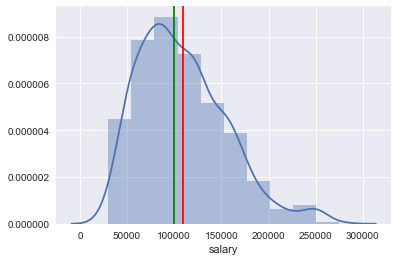

In [8]:
ax = sns.distplot(df['salary'], bins=10)
ax.axvline(df['salary'].mean(), c='r')
ax.axvline(df['salary'].median(), c='g')

In [9]:
twentieth = df['salary'].quantile(0.20)
eightieth = df['salary'].quantile(0.80)

In [10]:
def percent_classifier(col):    
    
    if col < twentieth:
        return 0
    elif col >= twentieth and col < eightieth:
        return 1 
    else:
        return 2

In [11]:
df['salary_class'] = df['salary'].apply(percent_classifier)

## Base Accuracy Score 

410 ads out of 664 fall into the largest group of salary ranges which give us approximately 62%. 


## Removing Irrelevant Words 



In [12]:
stop_words = stop_words.ENGLISH_STOP_WORDS

In [13]:
def remove_stop_words(row):
    
    words = row.split()
    clean = []
    for word in words:
        if word not in stop_words:
            clean.append(word)
            
    return ' '.join(clean)

In [14]:
job_desc = df['text'].apply(remove_stop_words).values
salary_class = df['salary_class'].values

### Creating a Dictionary Word to Index 

To start off, let's count how often each word appears in the data. We'll use this count to encode the text data. This resulting count is known as a [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model). We'll use it to select our vocabulary and build the word vectors. 

In [15]:
total_counts = Counter()
for text in job_desc:
    for word in text.split():
        total_counts[word] += 1

print("Total words in data set: ", len(total_counts))

Total words in data set:  1899


In [16]:
vocab = sorted(total_counts, key=total_counts.get, reverse=True)[:500]
print(vocab[:30])

['data', 'scientist', 'research', 'learning', 'new', 'machine', 'analyst', 'york', 'health', 'senior', 'analytic', 'chicago', 'team', 'python', 'science', 'experience', 'clinical', 'r', 'engineer', 'san', 'francisco', 'analysis', 'looking', 'los', 'angeles', 'public', 'modeling', 'statistical', 'company', 'predictive']


In [17]:
print(vocab[-1], ': ', total_counts[vocab[-1]])

bay :  4


In [18]:
word2idx = {}
for i, word in enumerate(vocab):
    word2idx[word] = i

In [19]:
with open('data/vocab.json', 'w') as outfile:
    json.dump(vocab, outfile)

In [20]:
with open('data/word2idx.json', 'w') as outfile:
    json.dump(word2idx, outfile)

### Convert Text to vector 

Now we can write a function that converts a some text to a word vector. The function will take a string of words as input and return a vector with the words counted up. Here's the general algorithm to do this:

* Initialize the word vector with [np.zeros](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html), it should be the length of the vocabulary.
* Split the input string of text into a list of words with `.split(' ')`. Again, if you call `.split()` instead, you'll get slightly different results than what we show here.
* For each word in that list, increment the element in the index associated with that word, which you get from `word2idx`.

**Note:** Since all words aren't in the `vocab` dictionary, you'll get a key error if you run into one of those words. You can use the `.get` method of the `word2idx` dictionary to specify a default returned value when you make a key error. For example, `word2idx.get(word, None)` returns `None` if `word` doesn't exist in the dictionary.

In [21]:
def text_to_vector(text):
    word_vec = np.zeros((1, len(vocab)))
    for word in text.split():
        if word in word2idx.keys():
            word_vec[0][word2idx[word]] += 1
            
    return np.array(word_vec)

In [22]:
word_vectors = np.zeros((len(job_desc), len(vocab)), dtype=np.int_)
for ii, text in enumerate(job_desc):
    word_vectors[ii] = text_to_vector(text)

In [23]:
# Printing out the first 5 word vectors
word_vectors[:5, :23]

array([[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
       [2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [2, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0]])

### Train, Validation, Test sets

Now that we have the word_vectors, we're ready to split our data into train, validation, and test sets. Remember that we train on the train data, use the validation data to set the hyperparameters, and at the very end measure the network performance on the test data. Here we're using the function `to_categorical` from TFLearn to reshape the target data so that we'll have two output units and can classify with a softmax activation function. We actually won't be creating the validation set here, TFLearn will do that for us later.

In [24]:
y = salary_class
records = len(salary_class)

shuffle = np.arange(records)
np.random.shuffle(shuffle)
test_fraction = 0.8

train_split, test_split = shuffle[:int(records*test_fraction)], shuffle[int(records*test_fraction):]
trainX, trainY = word_vectors[train_split,:], to_categorical(y[train_split], 3)
testX, testY = word_vectors[test_split,:], to_categorical(y[test_split], 3)

## Building the network

[TFLearn](http://tflearn.org/) lets you build the network by [defining the layers](http://tflearn.org/layers/core/). 

### Input layer

For the input layer, you just need to tell it how many units you have. For example, 

```
net = tflearn.input_data([None, 100])
```

would create a network with 100 input units. The first element in the list, `None` in this case, sets the batch size. Setting it to `None` here leaves it at the default batch size.

The number of inputs to your network needs to match the size of your data. For this example, we're using 500 element long vectors to encode our input data, so we need 500 input units.


### Adding layers

To add new hidden layers, you use 

```
net = tflearn.fully_connected(net, n_units, activation='ReLU')
```

This adds a fully connected layer where every unit in the previous layer is connected to every unit in this layer. The first argument `net` is the network you created in the `tflearn.input_data` call. It's telling the network to use the output of the previous layer as the input to this layer. You can set the number of units in the layer with `n_units`, and set the activation function with the `activation` keyword. You can keep adding layers to your network by repeated calling `net = tflearn.fully_connected(net, n_units)`.

### Output layer

The last layer you add is used as the output layer. Therefore, you need to set the number of units to match the target data. In this case we are predicting two classes, positive or negative sentiment. You also need to set the activation function so it's appropriate for your model. Again, we're trying to predict if some input data belongs to one of two classes, so we should use softmax.

```
net = tflearn.fully_connected(net, 2, activation='softmax')
```

### Training
To set how you train the network, use 

```
net = tflearn.regression(net, optimizer='sgd', learning_rate=0.1, loss='categorical_crossentropy')
```

Again, this is passing in the network you've been building. The keywords: 

* `optimizer` sets the training method, here stochastic gradient descent
* `learning_rate` is the learning rate
* `loss` determines how the network error is calculated. In this example, with the categorical cross-entropy.

Finally you put all this together to create the model with `tflearn.DNN(net)`. So it ends up looking something like 

```
net = tflearn.input_data([None, 10])                          # Input
net = tflearn.fully_connected(net, 5, activation='ReLU')      # Hidden
net = tflearn.fully_connected(net, 2, activation='softmax')   # Output
net = tflearn.regression(net, optimizer='sgd', learning_rate=0.1, loss='categorical_crossentropy')
model = tflearn.DNN(net)
```

> **Exercise:** Below in the `build_model()` function, you'll put together the network using TFLearn. You get to choose how many layers to use, how many hidden units, etc.

In [25]:
# Network building
def build_model():
    # This resets all parameters and variables, leave this here
    tf.reset_default_graph()
    
    # Inputs
    inputs = tflearn.input_data([None, 500])
    
    # Hidden layer(s)
    full_layer = tflearn.fully_connected(inputs, 500, activation='ReLU')
    drop = tflearn.dropout(full_layer, keep_prob=0.3)
    
    # Output layer(s)
    net = tflearn.fully_connected(drop, 3, activation='softmax')
    sgd = tflearn.optimizers.SGD(learning_rate=0.01, lr_decay=0.90, decay_step=1000)
    net = tflearn.regression(net, optimizer=sgd, loss='categorical_crossentropy')
    
    model = tflearn.DNN(net)
    
    return model

## Intializing the model

Next we need to call the `build_model()` function to actually build the model. In my solution I haven't included any arguments to the function, but you can add arguments so you can change parameters in the model if you want.

> **Note:** You might get a bunch of warnings here. TFLearn uses a lot of deprecated code in TensorFlow. Hopefully it gets updated to the new TensorFlow version soon.

In [26]:
model = build_model()

## Training the network

Now that we've constructed the network, saved as the variable `model`, we can fit it to the data. Here we use the `model.fit` method. You pass in the training features `trainX` and the training targets `trainY`. Below I set `validation_set=0.3` which reserves 30% of the data set as the validation set. You can also set the batch size and number of epochs with the `batch_size` and `n_epoch` keywords, respectively. Below is the code to fit our the network to our word vectors.

You can rerun `model.fit` to train the network further if you think you can increase the validation accuracy. Remember, all hyperparameter adjustments must be done using the validation set. **Only use the test set after you're completely done training the network.**

In [27]:
# Training
model.fit(trainX, trainY, validation_set=0.3, show_metric=True, batch_size=64, n_epoch=100)

Training Step: 599  | total loss: 0.83877 | time: 0.057s
| SGD | epoch: 100 | loss: 0.83877 - acc: 0.5757 -- iter: 320/371
Training Step: 600  | total loss: 0.83650 | time: 1.072s
| SGD | epoch: 100 | loss: 0.83650 - acc: 0.5759 | val_loss: 0.90355 - val_acc: 0.5375 -- iter: 371/371
--


In [28]:
model.fit(trainX, trainY, validation_set=0.3, show_metric=True, batch_size=64, n_epoch=500)

Training Step: 3599  | total loss: 0.43287 | time: 0.044s
| SGD | epoch: 600 | loss: 0.43287 - acc: 0.8878 -- iter: 320/371
Training Step: 3600  | total loss: 0.41484 | time: 1.059s
| SGD | epoch: 600 | loss: 0.41484 - acc: 0.8990 | val_loss: 0.53872 - val_acc: 0.7750 -- iter: 371/371
--


In [29]:
model.fit(trainX, trainY, validation_set=0.3, show_metric=True, batch_size=64, n_epoch=1000)

Training Step: 9599  | total loss: 0.12498 | time: 0.041s
| SGD | epoch: 1600 | loss: 0.12498 - acc: 0.9875 -- iter: 320/371
Training Step: 9600  | total loss: 0.12184 | time: 1.052s
| SGD | epoch: 1600 | loss: 0.12184 - acc: 0.9888 | val_loss: 0.33131 - val_acc: 0.8625 -- iter: 371/371
--


In [30]:
model.fit(trainX, trainY, validation_set=0.3, show_metric=True, batch_size=64, n_epoch=2000)

Training Step: 21599  | total loss: 0.06418 | time: 0.067s
| SGD | epoch: 3600 | loss: 0.06418 - acc: 0.9974 -- iter: 320/371
Training Step: 21600  | total loss: 0.06445 | time: 1.083s
| SGD | epoch: 3600 | loss: 0.06445 - acc: 0.9977 | val_loss: 0.24793 - val_acc: 0.9375 -- iter: 371/371
--


In [31]:
model.fit(trainX, trainY, validation_set=0.3, show_metric=True, batch_size=64, n_epoch=5000)

Training Step: 51599  | total loss: 0.07704 | time: 0.043s
| SGD | epoch: 8600 | loss: 0.07704 - acc: 0.9960 -- iter: 320/371
Training Step: 51600  | total loss: 0.07705 | time: 1.060s
| SGD | epoch: 8600 | loss: 0.07705 - acc: 0.9949 | val_loss: 0.08964 - val_acc: 0.9812 -- iter: 371/371
--


In [32]:
model.fit(trainX, trainY, validation_set=0.3, show_metric=True, batch_size=64, n_epoch=7000)

Training Step: 93599  | total loss: 0.09166 | time: 0.044s
| SGD | epoch: 15600 | loss: 0.09166 - acc: 0.9880 -- iter: 320/371
Training Step: 93600  | total loss: 0.08922 | time: 1.059s
| SGD | epoch: 15600 | loss: 0.08922 - acc: 0.9892 | val_loss: 0.06805 - val_acc: 0.9938 -- iter: 371/371
--


In [33]:
# Save a model
model.save('model/model.tfl')

INFO:tensorflow:/Users/leylamovahedi/dsi/dsi-sm/indeed-salary-prediction/model/model.tfl is not in all_model_checkpoint_paths. Manually adding it.


In [34]:
# Load a model
model.load('model/model.tfl')

INFO:tensorflow:Restoring parameters from /Users/leylamovahedi/dsi/dsi-sm/indeed-salary-prediction/model/model.tfl


## Testing

After you're satisified with your hyperparameters, you can run the network on the test set to measure its performance. Remember, *only do this after finalizing the hyperparameters*.

In [35]:
predictions = np.argmax(np.array(model.predict(testX)), axis=1)
actual = np.argmax(testY, axis=1)
test_accuracy = np.mean(predictions == actual)
print("Test accuracy: ", test_accuracy)

Test accuracy:  0.857142857143


In [36]:
test = extract_posts_to_df(keyword=['data scientist'], city_set=cities, max_results_per_city=10)

In [37]:
test = preprocess_wo_salary(test)

In [43]:
def predict_salary(df):
    
    salary = {'0':'below $66000', '1':'$66000 to $150000', '2':'above $150000'}
    
    texts = df['text'].apply(remove_stop_words).values
    test_vectors = np.zeros((len(texts), len(vocab)), dtype=np.int_)
    for ii, text in enumerate(texts):
        test_vectors[ii] = text_to_vector(text)
        
    predicted_salary_class = np.argmax(np.array(model.predict(test_vectors)), axis=1)
    df['predicted_salary_range'] = [salary[str(elm)] if str(elm) in salary.keys() else None for elm in predicted_salary_class]
    
    return df

In [44]:
predict_salary(test)

,city,company,location,summary,title,text,predicted_salary_range
0,los angeles,amazon corporate llc,"Manhattan Beach, CA",our natural language processing and machine le...,applied scientist,los angeles our natural language processing an...,$66000 to $150000
1,los angeles,goleta star,"Torrance, CA",experience with the hough transform support ve...,image analysis scientist,los angeles experience with the hough transfor...,$66000 to $150000
2,los angeles,anthem inc,"Downey, CA",model document and present strategic solution ...,healthcare data scientist 127549,los angeles model document and present strateg...,$66000 to $150000
3,los angeles,jet propulsion laboratory,"Pasadena, CA",this individual will be responsible for applyi...,data scientist i,los angeles this individual will be responsibl...,$66000 to $150000
4,los angeles,neohire south,"Century City, CA",proven ability to do analytic or modeling work...,data scientist,los angeles proven ability to do analytic or m...,$66000 to $150000
5,los angeles,sony pictures entertainment inc,"Culver City, CA 90232",reporting to senior vp analytic business insig...,data scientist,los angeles reporting to senior vp analytic bu...,above $150000
6,los angeles,spacex,"Hawthorne, CA",as a data scientist in this team you would ide...,data scientist,los angeles as a data scientist in this team y...,above $150000
7,los angeles,hulu,"Santa Monica, CA",we are looking for data scientist who are pass...,data scientist,los angeles we are looking for data scientist ...,$66000 to $150000
8,los angeles,air liquide,"Los Angeles, CA",cr er des relations solides avec les quipes re...,digital data scientist h f,los angeles cr er des relations solides avec l...,$66000 to $150000
9,los angeles,grindr,"Los Angeles, CA 90046",the data scientist will work cross functionall...,data scientist,los angeles the data scientist will work cross...,$66000 to $150000


In [46]:
test.to_csv('data/predicted_salary_range.csv')